# Coursera Power Plant

This notebook solves the machine learning project proposed in Coursera - AI Product Management Specialization.

The dataset can be found in: \
https://www.coursera.org/learn/machine-learning-foundations-for-product-managers/peer/U0ryB/course-project \
\
We are going to:\
1- Read, evaluate and split the dataset into training and testing dataset\
2- Test the model with linear regression and random forest regression, testing different features and parameters\
3- Compare and evaluate the performances

In [51]:
# import basic libraries and read input
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from math import floor

df_input = pd.read_csv('CCPP_data.csv')

## Input dataset checking and spliting

In [52]:
# checking the dataset structure
print(df_input.head())
print()
print(df_input.info())
print()
print(df_input.describe())

      AT      V       AP     RH      PE
0  14.96  41.76  1024.07  73.17  463.26
1  25.18  62.96  1020.04  59.08  444.37
2   5.11  39.40  1012.16  92.14  488.56
3  20.86  57.32  1010.24  76.64  446.48
4  10.82  37.50  1009.23  96.62  473.90

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB
None

                AT            V           AP           RH           PE
count  9568.000000  9568.000000  9568.000000  9568.000000  9568.000000
mean     19.651231    54.305804  1013.259078    73.308978   454.365009
std       7.452473    12.707893     5.938784    14.600269    17.066995
min       1.810000    25.360000   992.890000    25.560000   42

From the input we can see that we have the features AT,V,AP,RH which are all numerical\
The target PE is also numerical. And none of the features or target have null values.\
\
Since we are dealing with multiple features and we do not have an specific metric requirement,
our goal will be to create regression models to minimize the RMSE.

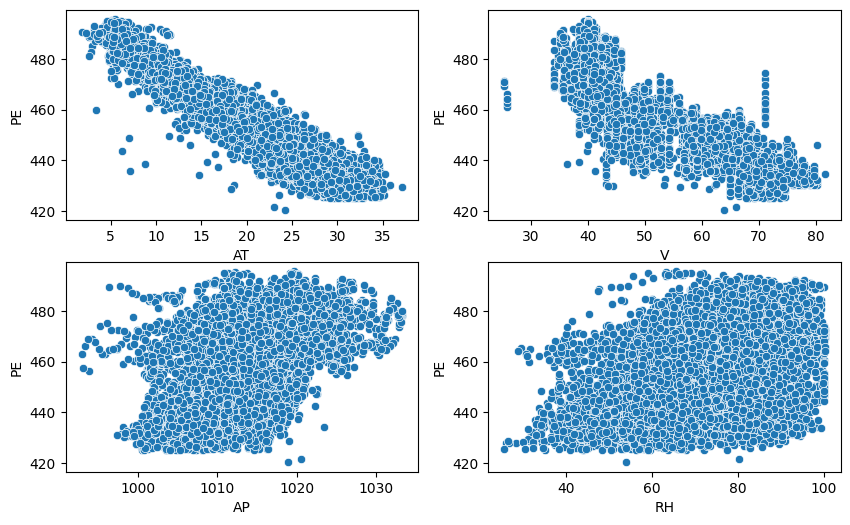

In [53]:
# dataset visualization
list_feature = ['AT','V','AP','RH']
list_target = ['PE']

f, axes = plt.subplots(2, 2,figsize=(10, 6))
for idx, feature in enumerate(list_feature):
    sns.scatterplot(data=df_input, x=feature, y=list_target[0], ax=axes[floor(idx/2),idx%2],sizes=[2,2])

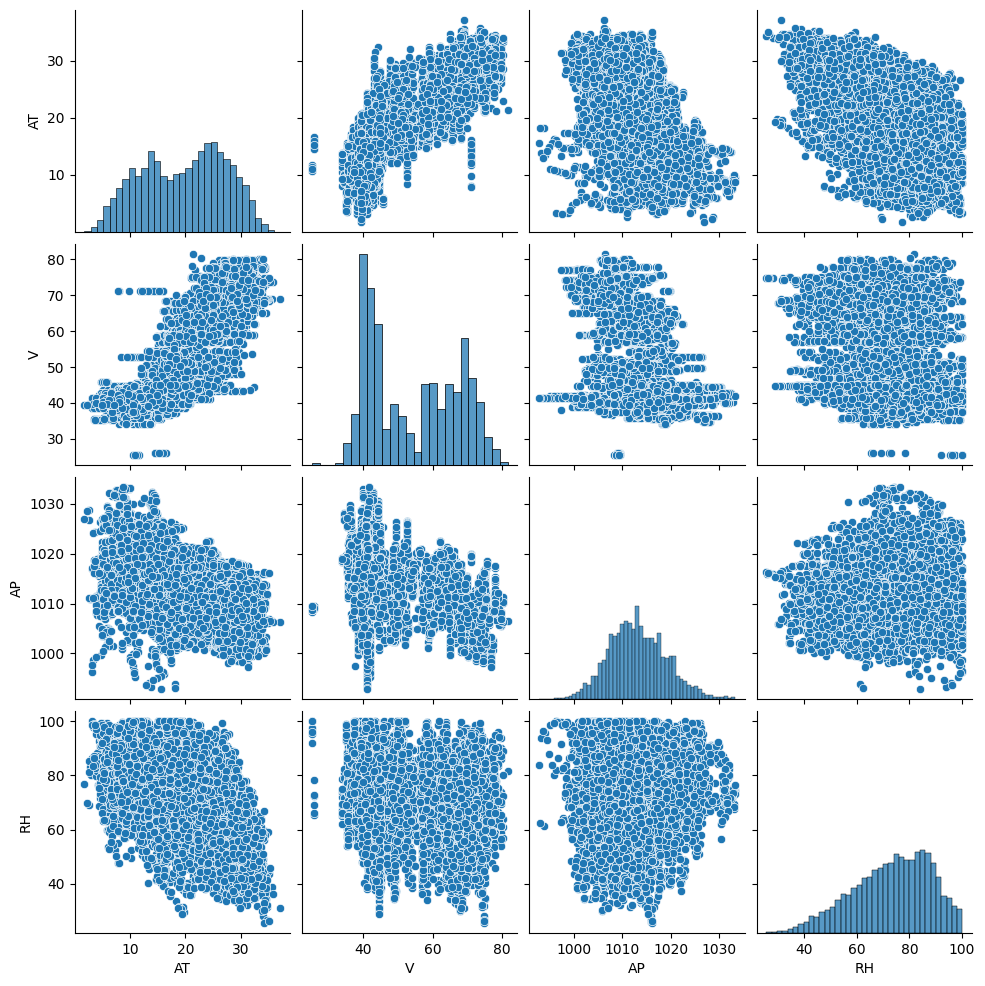

In [54]:
# pair plot
sns.pairplot(df_input[list_feature])

<Axes: >

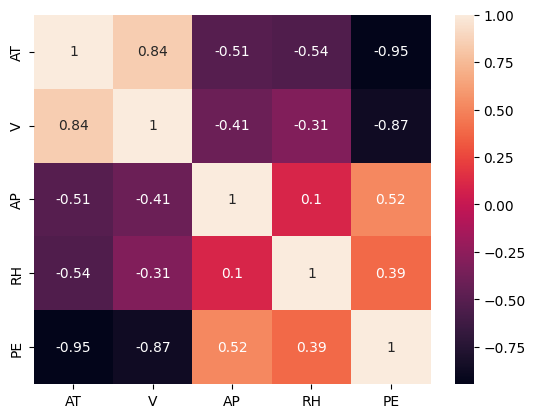

In [55]:
# dataset correlation
sns.heatmap(df_input.corr(),annot=True)

Analysing the correlation heatmap, we can see that the variables have significant correlation to the target (PE).\
However, AT and V also have a hight correlation between themselves.

In [56]:
# Spliting the dataset into training (90%) and testing (10%) with random shuffling
df_train, df_test = train_test_split(df_input, shuffle=True, test_size=0.1, random_state=10)

## Linear Regression

In [67]:
model_linear = LinearRegression()

ypred = model_linear.fit(X=df_input[list_feature], y=df_input[list_target]).predict(df_input[list_feature])

score = r2_score(y_true=df_input[list_target], y_pred=ypred)
RMSEscore = mean_squared_error(y_true=df_input[list_target], y_pred=ypred)

print('R2 scores: {}'.format(score))
print('RMSE mean: {:.3f}'.format(RMSEscore))

R2 scores: 0.9286960898122536
RMSE mean: 20.767


In [68]:
# now we can test what happens if we remove some of the lesser correlated feature (RH and AP)
list_feature_new = [feature for feature in list_feature if feature not in ['RH','AP']]

model_linear = LinearRegression()

ypred = model_linear.fit(X=df_input[list_feature_new], y=df_input[list_target]).predict(df_input[list_feature_new])

score = r2_score(y_true=df_input[list_target], y_pred=ypred)
RMSEscore = mean_squared_error(y_true=df_input[list_target], y_pred=ypred)

print('R2 scores: {}'.format(score))
print('RMSE mean: {:.3f}'.format(RMSEscore))

R2 scores: 0.9157294412114197
RMSE mean: 24.544


By removing two features RH and AP we increase the RMSE by about 18.18%.\
The decision to keep or not is a tradeoff, in this case we will keep all the features.

## Random forest

In [60]:
kfold = KFold(n_splits=5, shuffle=True, random_state=10)

model_randomForest = RandomForestRegressor(n_estimators=10, max_depth=20, max_features=3, random_state=10)
scores = cross_val_score(model_randomForest, df_train[list_feature], np.array(df_train[list_target]).ravel(), cv=kfold,
    scoring='r2')
RMSEscores = cross_val_score(model_randomForest, df_train[list_feature], np.array(df_train[list_target]).ravel(), cv=kfold,
    scoring='neg_mean_squared_error')

print('R2 scores: {}'.format(scores))
print('R2 mean: {:.3f}'.format(sum(scores)/len(scores)))
print('RMSE scores: {}'.format(RMSEscores))
print('RMSE mean: {:.3f}'.format(-1*sum(RMSEscores)/len(RMSEscores)))

R2 scores: [0.96013607 0.95823304 0.9462523  0.95711158 0.95798789]
R2 mean: 0.956
RMSE scores: [-11.40333764 -11.9087455  -15.59645399 -12.52199024 -12.63553546]
RMSE mean: 12.813


With a simple random forest configuration, using few trees (10) and shallow trees (20) we already got better results than using linear regression.\
Next, we will do a grid search to test the model with [10, 50] trees, [10, 30] max_depth and [3, 4] features:

In [61]:
def randomForestSearch(trees = 10, depth=20, features=3):
    kfold = KFold(n_splits=5, shuffle=True, random_state=10)

    model_randomForest = RandomForestRegressor(n_estimators=trees, max_depth=depth, max_features=features, random_state=10)
    scores = cross_val_score(model_randomForest, df_train[list_feature], np.array(df_train[list_target]).ravel(), cv=kfold,
        scoring='r2')
    RMSEscores = cross_val_score(model_randomForest, df_train[list_feature], np.array(df_train[list_target]).ravel(), cv=kfold,
        scoring='neg_mean_squared_error')

    return [sum(scores)/len(scores), -1*sum(RMSEscores)/len(RMSEscores)]

In [62]:
gridSearch = pd.DataFrame(data=[[t,d,f] for t in [10,50] for d in [10, 30] for f in [3, 4]],
    columns=['trees','depth','features'])
gridSearch['R2'] = None
gridSearch['RMSE'] = None

for idx, row in gridSearch.iterrows():
    result = randomForestSearch(row['trees'], row['depth'], row['features'])
    gridSearch.at[idx,'R2'] = result[0]
    gridSearch.at[idx,'RMSE'] = result[1]

In [63]:
gridSearch.sort_values(by='RMSE')

,trees,depth,features,R2,RMSE
6,50,30,3,0.960593,11.462096
7,50,30,4,0.959318,11.831586
2,10,30,3,0.956169,12.745428
4,50,10,3,0.955992,12.798811
5,50,10,4,0.955468,12.950155
3,10,30,4,0.955375,12.973743
0,10,10,3,0.953386,13.554944
1,10,10,4,0.95274,13.738824


Taking into account our grid search, we see that the best candidate for hyperparameters are:\
trees: 50, max depth: 30, max features: 3

In [64]:
# Training and scoring the final random forest model
model_randomForest = RandomForestRegressor(n_estimators=50, max_depth=30, max_features=3, random_state=10)
model_randomForest = model_randomForest.fit(X=df_train[list_feature], y=np.array(df_train[list_target]).ravel())

ypred = model_randomForest.predict(df_test[list_feature])

scores = r2_score(y_true=df_test[list_target], y_pred=ypred)
RMSEscores = mean_squared_error(y_true=df_test[list_target], y_pred=ypred)

print('Regression final R2 score: {:.3f}'.format(score))
print('Regression final RMSE score: {:.3f}'.format(RMSEscores))

Regression final R2 score: 0.937
Regression final RMSE score: 9.417


Using a grid search to tune some hyper parameters it was possible to acchieve a better perfomance for our regression model.